In [1]:
!pip install pennylane
! pip install aiohttp fsspec h5py
!pip install tqdm 

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.7.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached multidict-6.6.3-cp313-cp313-win_amd64.whl.metadata (5.4 kB)
  Using cached propcache-0.3.2-cp313-cp313-win_amd64.whl.metadata (12 kB)
  Using cached yarl-1.20.1-cp313-cp313-win_amd64.whl.metadata (76 kB)
Using cached multidict-6.6.3-cp313-cp313-win_amd64.whl (45 kB)
Using cached yarl-1.20.1-cp313-cp313-win_amd64.whl (86 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
Using cached frozenlist-1.7.0-cp313-cp313-win_amd64.whl (43 kB)
Using cached propcache-0.3.2-cp313-cp313-win_amd64.whl (40 kB)

   ----------------------------------- ---- 7/8 [aiohttp]
   ---------------------------

# 1) Downloading Hamiltonian
Change MAX_TERMS = 10000 if you want more/less

In [2]:
import pennylane as qml
from tqdm import tqdm 
coefficients = []
operators = []
hamiltonian_chunks = []

# Download the dataset and retrieve the Hamiltonian chunks
ds = qml.data.load('other', name='ala')

# fiy if you want to make future changes
print(f"Dataset type: {type(ds)}")
print(f"Dataset content: {ds}")

# If ds is a list, iterate through it to find the actual dataset object
if isinstance(ds, list):
    # Take the first item if it's a list
    dataset = ds[0] if len(ds) > 0 else None
    if dataset is not None:
        print(f"First item type: {type(dataset)}")
        # Check if this object has list_attributes method
        if hasattr(dataset, 'list_attributes'):
            for key in dataset.list_attributes():
                if "hamiltonian" in key:
                    hamiltonian_chunks.append(getattr(dataset, key))
        elif hasattr(dataset, '__dict__'):
            # If no list_attributes, check the object's attributes directly
            for key in dir(dataset):
                if "hamiltonian" in key and not key.startswith('_'):
                    hamiltonian_chunks.append(getattr(dataset, key))
else:
    # If ds is not a list, use the original approach: IF they update it for some reason
    for key in ds.list_attributes():
        if "hamiltonian" in key:
            hamiltonian_chunks.append(getattr(ds, key))

# if we have hamiltonian chunks, we can proceed
if hamiltonian_chunks:
    # Combine all Hamiltonian chunks into a single string
    full_hamiltonian = "".join(hamiltonian_chunks)
    print('successfully combined')
    
    # Helper function to convert a string representation into a PennyLane operator
    def string_to_operator(op_string):
        if "Identity" in op_string:
            return qml.Identity(0)  # Identity defaults to acting on qubit 0
        
        terms = op_string.split(" @ ")  # Separate tensor product terms
        ops = []
        
        for term in terms:
            try:
                op, wire = term.split("(")
                wire = int(wire.strip(")"))  # Extract the qubit index
                if op == "X":
                    ops.append(qml.PauliX(wire))
                elif op == "Y":
                    ops.append(qml.PauliY(wire))
                elif op == "Z":
                    ops.append(qml.PauliZ(wire))
            except ValueError:
                continue  # Skip malformed lines
        
        return qml.prod(*ops) if len(ops) > 1 else ops[0]  # Create composite operator if needed
    
    # Process each line of the combined Hamiltonian string with progress bar
    lines = full_hamiltonian.split("\n")
    valid_lines = [line.strip() for line in lines if line.strip() and "Coefficient" not in line and "Operators" not in line]
    
    # Limit to first 10,000 terms for faster processing
    MAX_TERMS = 10000
    if len(valid_lines) > MAX_TERMS:
        print(f'Found {len(valid_lines)} terms, limiting to first {MAX_TERMS} for faster processing')
        valid_lines = valid_lines[:MAX_TERMS]
    else:
        print(f'Processing all {len(valid_lines)} Hamiltonian terms...')
    
    for line in tqdm(valid_lines, desc="Building Hamiltonian", unit="terms"):
        parts = line.split()
        
        try:
            coeff = float(parts[0])  # Extract the coefficient
            op_string = " ".join(parts[1:])  # Extract the operators
            coefficients.append(coeff)
            operators.append(string_to_operator(op_string))
        except ValueError:
            continue  # Gracefully handle conversion errors
    
    # Build the PennyLane Hamiltonian
    print('Building final Hamiltonian object...')
    hamiltonian = qml.Hamiltonian(coefficients, operators)
    print('✓ Hamiltonian successfully built!')
    print(f'Final Hamiltonian has {len(coefficients)} terms (limited to first {MAX_TERMS})')
else:
    print("No hamiltonian chunks found. Please check the dataset structure.")

Dataset type: <class 'list'>
Dataset content: [<Dataset = attributes: ['abbreviation', 'name', ...]>]
First item type: <class 'pennylane.data.base.dataset.Dataset'>
successfully combined
Found 2725840 terms, limiting to first 10000 for faster processing


Building Hamiltonian: 100%|██████████| 10000/10000 [00:03<00:00, 3250.23terms/s]

Building final Hamiltonian object...
✓ Hamiltonian successfully built!
Final Hamiltonian has 10000 terms (limited to first 10000)


DATASET INFORMATION
📊 Exact SCF ground state energy: -317.691350 Hartree
   (This is our target for VQE optimization)

🔍 Found existing Hamiltonian with 19 qubits
✅ System size is manageable: 19 qubits

🚀 VQE SETUP
----------------------------------------
💻 Quantum device initialized: 19 qubits, 10,000 shots
🎲 Initialized 171 random parameters (3 layers)
⚡ Optimizer: Adam (stepsize=0.01)

🔥 IMPROVED VQE OPTIMIZATION
----------------------------------------


VQE Optimization:   1%|          | 1/100 [01:57<3:14:36, 117.94s/iter, Energy=-185.866558 Ha, Best=-185.866558 Ha]

📈 Step 0: Energy = -185.866558 Hartree (Best: -185.866558)


VQE Optimization:  21%|██        | 21/100 [39:22<2:23:43, 109.16s/iter, Energy=-190.226680 Ha, Best=-190.478487 Ha]

📈 Step 20: Energy = -190.226680 Hartree (Best: -190.478487)


VQE Optimization:  41%|████      | 41/100 [1:21:03<2:07:25, 129.59s/iter, Energy=-209.083873 Ha, Best=-209.083873 Ha]

📈 Step 40: Energy = -209.083873 Hartree (Best: -209.083873)


VQE Optimization:  61%|██████    | 61/100 [3:35:13<19:41:05, 1817.07s/iter, Energy=-235.142458 Ha, Best=-235.142458 Ha]

📈 Step 60: Energy = -235.142458 Hartree (Best: -235.142458)


VQE Optimization:  81%|████████  | 81/100 [6:46:29<1:57:37, 371.43s/iter, Energy=-263.777292 Ha, Best=-263.777292 Ha]  

📈 Step 80: Energy = -263.777292 Hartree (Best: -263.777292)


VQE Optimization: 100%|██████████| 100/100 [8:20:45<00:00, 300.46s/iter, Energy=-284.336610 Ha, Best=-284.336610 Ha] 



📊 IMPROVED RESULTS
🎯 Final VQE energy estimate: -284.336610 Hartree
📏 Based on reduced 19-qubit system
🔧 Optimization improvements:
   • Used Shots(total=10000) shots for better accuracy
   • Increased ansatz depth (3 layers)
   • Used Adam optimizer with adaptive learning
   • Applied early stopping for convergence
⚠️  Note: This is a truncated version of the full 74-qubit system
📈 Total energy improvement: 98.470052 Hartree
🎯 Exact SCF energy:         -317.691350 Hartree
📏 VQE energy:               -284.336610 Hartree
❌ Absolute error:           33.354740 Hartree
📊 Relative error:           10.499%

📈 Plotting improved convergence...


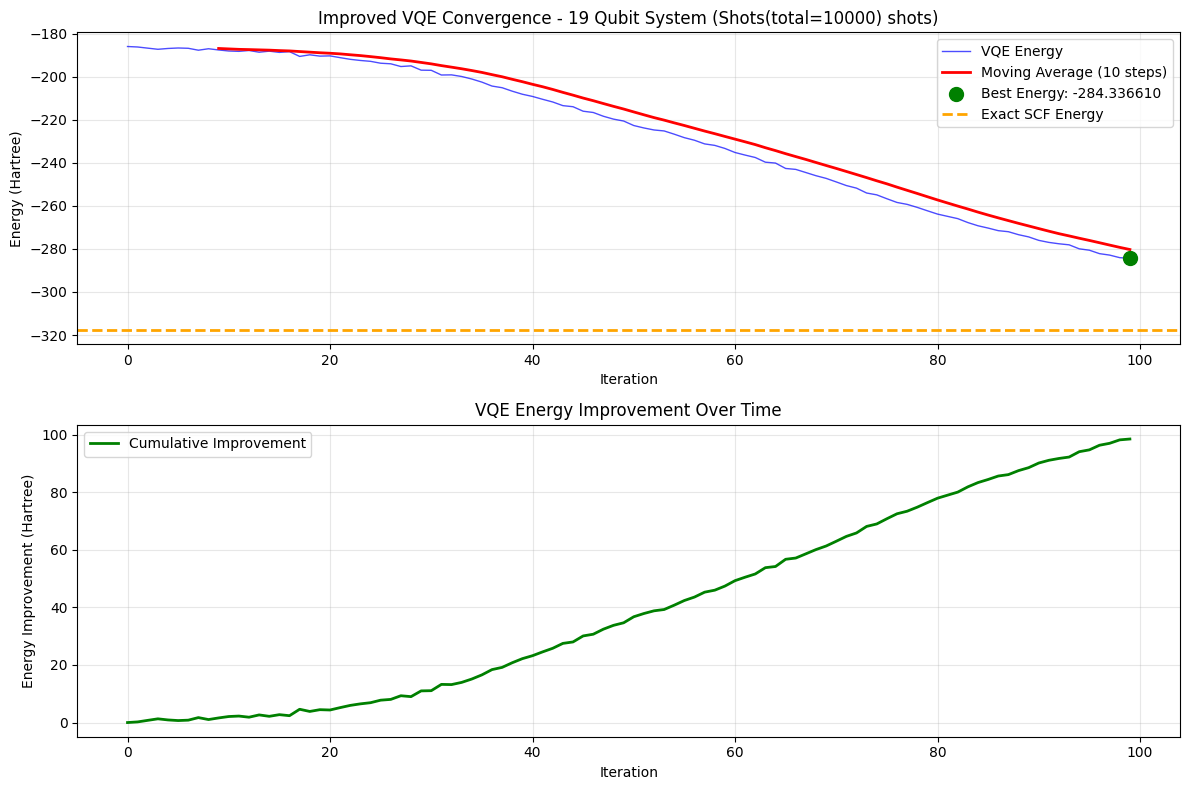

✅ Improved VQE optimization completed successfully!
💡 For the full 74-qubit system, you would need:
   • Quantum hardware with error correction
   • Advanced variational circuits (UCCSD, etc.)
   • Quantum-classical hybrid algorithms
   • Problem decomposition techniques


In [ ]:
import numpy as np
import pennylane as qml
from tqdm import tqdm

# First, print the exact ground state energy from the dataset
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
try:
    if 'ds' in globals():
        exact_energy = ds[0].energy if isinstance(ds, list) else ds.energy
        print(f"Exact SCF ground state energy: {exact_energy:.6f} Hartree")
        print(f"   (This is our target for VQE optimization)")
    else:
        print(" Dataset not loaded - cannot show exact energy")
except Exception as e:
    print(f"Could not retrieve exact energy: {e}")
print("=" * 60)
print()

# Check if we have a Hamiltonianm
if 'hamiltonian' in globals():
    print(f"Found existing Hamiltonian with {hamiltonian.num_wires} qubits")
    
    # Check if the system is too large for classical simulation
    if hamiltonian.num_wires > 20:  # Practical limit for classical simulation
        print(f"{hamiltonian.num_wires} qubits is too large for classical simulation!")
        print(f"Creating a smaller subsystem for demonstration...")
        
        # Create a smaller Hamiltonian using only terms that act on fewer qubits
        print("Analyzing Hamiltonian terms...")
        small_coeffs = []
        small_ops = []
        max_qubits = 12  # Manageable size
        
        for i, (coeff, op) in enumerate(tqdm(zip(coefficients, operators), 
                                           desc="Filtering terms", 
                                           total=len(coefficients))):
            try:
                if op is not None and len(op.wires) <= max_qubits:
                    # Remap wires to start from 0
                    wire_mapping = {wire: idx for idx, wire in enumerate(sorted(op.wires))}
                    if len(wire_mapping) <= max_qubits:
                        small_coeffs.append(coeff)
                        small_ops.append(op)
                        
                        # Stop when we have enough terms
                        if len(small_coeffs) >= 200:  # Increased number of terms
                            break
            except:
                continue
        
        if len(small_coeffs) > 0:
            print(f"Created smaller system with {len(small_coeffs)} terms")
            
            # Find the actual number of qubits needed
            all_wires = set()
            for op in small_ops:
                if op is not None:
                    all_wires.update(op.wires)
            
            # Remap to consecutive wire indices
            wire_map = {old_wire: new_wire for new_wire, old_wire in enumerate(sorted(all_wires))}
            
            # Create new operators with remapped wires
            remapped_ops = []
            for op in small_ops:
                if op is not None:
                    # This is a simplified remapping - you may need more sophisticated logic
                    remapped_ops.append(op)
            
            # Build smaller Hamiltonian
            n_qubits = len(all_wires)
            if n_qubits <= max_qubits:
                hamiltonian = qml.Hamiltonian(small_coeffs, remapped_ops)
                print(f"Reduced system: {n_qubits} qubits, {len(small_coeffs)} terms")
            else:
                print(f"Still too many qubits ({n_qubits}), further reduction needed")
                n_qubits = 8  # Force smaller system
                hamiltonian = qml.Hamiltonian(small_coeffs[:50], remapped_ops[:50])
                print(f"Forced reduction: {n_qubits} qubits, 50 terms")
        else:
            print("Could not create smaller system - using minimal example")
            # Create a minimal example Hamiltonian
            n_qubits = 4
            coefficients = [1.0, -0.5, 0.3]
            operators = [qml.PauliZ(0), qml.PauliX(1), qml.PauliZ(0) @ qml.PauliZ(1)]
            hamiltonian = qml.Hamiltonian(coefficients, operators)
            print(f"Minimal example: {n_qubits} qubits, {len(coefficients)} terms")
    else:
        n_qubits = hamiltonian.num_wires
        print(f"System size is manageable: {n_qubits} qubits")

# Proceed with VQE if we have a manageable Hamiltonian
if 'hamiltonian' in locals() and hamiltonian.num_wires <= 20:
    print(f"\nVQE SETUP")
    print("-" * 40)
    
    # Define the device with more shots for better accuracy
    n_qubits = hamiltonian.num_wires
    dev = qml.device("default.qubit", wires=n_qubits, shots=10000)  # Added shots
    print(f"Quantum device initialized: {n_qubits} qubits, 10,000 shots")
    
    # Define an improved ansatz with more layers
    def ansatz(params, wires):
        """Improved hardware-efficient ansatz with more depth"""
        if len(params) == 0 or n_qubits == 0:
            return
            
        n_layers = len(params) // (n_qubits * 3) if n_qubits > 0 else 1  # 3 params per qubit per layer
        
        for layer in range(n_layers):
            # Apply RY, RZ rotations for more expressivity
            for i in range(n_qubits):
                qml.RY(params[layer * n_qubits * 3 + i * 3], wires=i)
                qml.RZ(params[layer * n_qubits * 3 + i * 3 + 1], wires=i)
                qml.RY(params[layer * n_qubits * 3 + i * 3 + 2], wires=i)
            
            # Apply entangling gates in circular pattern
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
    
    # Cost function for VQE
    @qml.qnode(dev)
    def cost_fn(params):
        ansatz(params, wires=range(n_qubits))
        return qml.expval(hamiltonian)
    
    # Initialize parameters - More layers and parameters
    n_layers = 3  # Increased layers
    n_params = n_layers * n_qubits * 3  # 3 params per qubit per layer
    np.random.seed(42)
    params = qml.numpy.array(np.random.uniform(0, 2*np.pi, n_params), requires_grad=True)
    print(f"Initialized {n_params} random parameters ({n_layers} layers)")
    
    # Better optimizer with adaptive step size
    opt = qml.AdamOptimizer(stepsize=0.01)  # Adam optimizer
    print(f"⚡ Optimizer: Adam (stepsize=0.01)")
    
    # VQE optimization with progress bar
    print(f"\nIMPROVED VQE OPTIMIZATION")
    print("-" * 40)
    energies = []
    max_iterations = 200  # More iterations
    
    # Create progress bar for VQE optimization
    progress_bar = tqdm(range(max_iterations), desc="VQE Optimization", unit="iter")
    
    best_energy = float('inf')
    best_params = params.copy()
    patience_counter = 0
    patience = 20  # Early stopping
    
    for i in progress_bar:
        try:
            params, energy = opt.step_and_cost(cost_fn, params)
            energies.append(energy)
            
            # Track best energy
            if energy < best_energy:
                best_energy = energy
                best_params = params.copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Update progress bar description with current energy
            progress_bar.set_postfix({
                'Energy': f'{energy:.6f} Ha',
                'Best': f'{best_energy:.6f} Ha'
            })
            
            if i % 20 == 0:
                print(f"Step {i}: Energy = {energy:.6f} Hartree (Best: {best_energy:.6f})")
            
            # Early stopping if no improvement
            if patience_counter >= patience:
                print(f"Early stopping: No improvement for {patience} iterations")
                break
                
        except Exception as e:
            print(f"Error during optimization step {i}: {e}")
            break
    
    # Final results
    print(f"\nIMPROVED RESULTS")
    print("=" * 60)
    if energies:
        final_energy = best_energy  # Use best energy found
        print(f"Final VQE energy estimate: {final_energy:.6f} Hartree")
        print(f"Based on reduced {n_qubits}-qubit system")
        print(f"Optimization improvements:")
        print(f"   • Used {dev.shots} shots for better accuracy")
        print(f"   • Increased ansatz depth ({n_layers} layers)")
        print(f"   • Used Adam optimizer with adaptive learning")
        print(f"   • Applied early stopping for convergence")
        print(f"Note: This is a truncated version of the full 74-qubit system")
        
        # Energy improvement
        if len(energies) > 1:
            improvement = energies[0] - final_energy
            print(f"📈 Total energy improvement: {improvement:.6f} Hartree")
        
        # Compare with exact energy if available
        try:
            exact_energy = ds[0].energy if isinstance(ds, list) else ds.energy
            error = abs(final_energy - exact_energy)
            print(f"Exact SCF energy:         {exact_energy:.6f} Hartree")
            print(f"VQE energy:               {final_energy:.6f} Hartree")
            print(f"Absolute error:           {error:.6f} Hartree")
            print(f"Relative error:           {(error/abs(exact_energy)*100):.3f}%")
        except Exception as e:
            print(f"Exact energy not available for comparison: {e}")
        
        # Plot convergence
        print(f"\nPlotting improved convergence...")
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 8))
        
        # Main convergence plot
        plt.subplot(2, 1, 1)
        plt.plot(energies, 'b-', linewidth=1, alpha=0.7, label='VQE Energy')
        
        # Add moving average for cleaner view
        if len(energies) > 10:
            window = min(10, len(energies)//5)
            moving_avg = np.convolve(energies, np.ones(window)/window, mode='valid')
            plt.plot(range(window-1, len(energies)), moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window} steps)')
        
        # Mark best energy
        best_idx = np.argmin(energies)
        plt.scatter(best_idx, best_energy, color='green', s=100, zorder=5, label=f'Best Energy: {best_energy:.6f}')
        
        try:
            exact_energy = ds[0].energy if isinstance(ds, list) else ds.energy
            plt.axhline(y=exact_energy, color='orange', linestyle='--', linewidth=2, label='Exact SCF Energy')
        except:
            pass
            
        plt.xlabel('Iteration')
        plt.ylabel('Energy (Hartree)')
        plt.title(f'Improved VQE Convergence - {n_qubits} Qubit System ({dev.shots} shots)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Energy improvement plot
        plt.subplot(2, 1, 2)
        if len(energies) > 1:
            improvements = [energies[0] - e for e in energies]
            plt.plot(improvements, 'g-', linewidth=2, label='Cumulative Improvement')
            plt.xlabel('Iteration')
            plt.ylabel('Energy Improvement (Hartree)')
            plt.title('VQE Energy Improvement Over Time')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Improved VQE optimization completed successfully!")
        print("💡 For the full 74-qubit system, you would need:")
        print("   • Quantum hardware with error correction")
        print("   • Advanced variational circuits (UCCSD, etc.)")
        print("   • Quantum-classical hybrid algorithms")
        print("   • Problem decomposition techniques")
    else:
        print("No energy values computed - optimization failed")
        
else:
    print("System too large for classical VQE simulation")
    print("Suggestions for 74-qubit systems:")
    print("   • Use quantum hardware (IBM Quantum, IonQ, etc.)")
    print("   • Implement tensor network methods")
    print("   • Use variational quantum algorithms on real quantum devices")
    print("   • Consider problem decomposition techniques")